In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
df1 = pd.read_csv('../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_Less_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_More_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i+1 for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'choice']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(ts_df[['rt', 'choice']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(5272, 5) (2283, 5)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 114       
                                                                 
Total params: 482 (1.88 KB)
Trainable params: 482 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 155s 155s/step - loss: 51046.3984
Epoch 2/3000
1/1 [==============================] - 0s 49ms/step - loss: 50650.2188
Epoch 3/3000
1/1 [==============================] - 0s 44ms/step - loss: 50372.4727
Epoch 4/3000
1/1 [==============================] - 0s 43ms/step - loss: 50145.9766
Epoch 5/3000
1/1 [==============================] - 0s 36ms/step - loss: 49949.4883
Epoch 6/3000
1/1 [==============================] - 0s 37ms/step - loss: 49772.7969
Epoch 7/3000
1/1 [==============================] - 0s 36ms/step - loss: 49609.8125
Epoch 8/3000
1/1 [==============================] - 0s 37ms/step - loss: 49456.4609
Epoch 9/3000
1/1 [==============================] - 0s 34ms/step - loss: 49309.7891
Epoch 10/3000
1/1 [==============================] - 0s 35ms/step - loss: 49167.6406
Epoch 11/3000
1/1 [==============================] - 0s 41ms/step - loss: 49028.4531
Epoch 12/3000
1/1 [==============================] - 0s 36ms/step - loss

1/1 [==============================] - 0s 55ms/step - loss: 41573.7617
Epoch 98/3000
1/1 [==============================] - 0s 55ms/step - loss: 41523.4219
Epoch 99/3000
1/1 [==============================] - 0s 51ms/step - loss: 41473.5703
Epoch 100/3000
1/1 [==============================] - 0s 52ms/step - loss: 41424.2031
Epoch 101/3000
1/1 [==============================] - 0s 49ms/step - loss: 41375.3164
Epoch 102/3000
1/1 [==============================] - 0s 52ms/step - loss: 41326.9023
Epoch 103/3000
1/1 [==============================] - 0s 52ms/step - loss: 41278.9492
Epoch 104/3000
1/1 [==============================] - 0s 51ms/step - loss: 41231.4531
Epoch 105/3000
1/1 [==============================] - 0s 49ms/step - loss: 41184.4062
Epoch 106/3000
1/1 [==============================] - 0s 50ms/step - loss: 41137.8008
Epoch 107/3000
1/1 [==============================] - 0s 48ms/step - loss: 41091.6328
Epoch 108/3000
1/1 [==============================] - 0s 48ms/step - lo

1/1 [==============================] - 0s 51ms/step - loss: 38263.5938
Epoch 193/3000
1/1 [==============================] - 0s 54ms/step - loss: 38239.0664
Epoch 194/3000
1/1 [==============================] - 0s 55ms/step - loss: 38214.6719
Epoch 195/3000
1/1 [==============================] - 0s 57ms/step - loss: 38190.4141
Epoch 196/3000
1/1 [==============================] - 0s 55ms/step - loss: 38166.2812
Epoch 197/3000
1/1 [==============================] - 0s 52ms/step - loss: 38142.2852
Epoch 198/3000
1/1 [==============================] - 0s 51ms/step - loss: 38118.4141
Epoch 199/3000
1/1 [==============================] - 0s 53ms/step - loss: 38094.6719
Epoch 200/3000
1/1 [==============================] - 0s 56ms/step - loss: 38071.0547
Epoch 201/3000
1/1 [==============================] - 0s 55ms/step - loss: 38047.5625
Epoch 202/3000
1/1 [==============================] - 0s 55ms/step - loss: 38024.1992
Epoch 203/3000
1/1 [==============================] - 0s 53ms/step - 

1/1 [==============================] - 0s 53ms/step - loss: 36367.2344
Epoch 288/3000
1/1 [==============================] - 0s 61ms/step - loss: 36350.5703
Epoch 289/3000
1/1 [==============================] - 0s 56ms/step - loss: 36333.9531
Epoch 290/3000
1/1 [==============================] - 0s 54ms/step - loss: 36317.3828
Epoch 291/3000
1/1 [==============================] - 0s 51ms/step - loss: 36300.8672
Epoch 292/3000
1/1 [==============================] - 0s 51ms/step - loss: 36284.3906
Epoch 293/3000
1/1 [==============================] - 0s 51ms/step - loss: 36267.9648
Epoch 294/3000
1/1 [==============================] - 0s 53ms/step - loss: 36251.5781
Epoch 295/3000
1/1 [==============================] - 0s 51ms/step - loss: 36235.2422
Epoch 296/3000
1/1 [==============================] - 0s 51ms/step - loss: 36218.9531
Epoch 297/3000
1/1 [==============================] - 0s 56ms/step - loss: 36202.7031
Epoch 298/3000
1/1 [==============================] - 0s 57ms/step - 

1/1 [==============================] - 0s 50ms/step - loss: 34949.4766
Epoch 383/3000
1/1 [==============================] - 0s 50ms/step - loss: 34935.9336
Epoch 384/3000
1/1 [==============================] - 0s 52ms/step - loss: 34922.4062
Epoch 385/3000
1/1 [==============================] - 0s 50ms/step - loss: 34908.9141
Epoch 386/3000
1/1 [==============================] - 0s 51ms/step - loss: 34895.4336
Epoch 387/3000
1/1 [==============================] - 0s 50ms/step - loss: 34881.9766
Epoch 388/3000
1/1 [==============================] - 0s 53ms/step - loss: 34868.5469
Epoch 389/3000
1/1 [==============================] - 0s 51ms/step - loss: 34855.1328
Epoch 390/3000
1/1 [==============================] - 0s 51ms/step - loss: 34841.7422
Epoch 391/3000
1/1 [==============================] - 0s 51ms/step - loss: 34828.3750
Epoch 392/3000
1/1 [==============================] - 0s 52ms/step - loss: 34815.0273
Epoch 393/3000
1/1 [==============================] - 0s 56ms/step - 

1/1 [==============================] - 0s 50ms/step - loss: 33748.8281
Epoch 478/3000
1/1 [==============================] - 0s 52ms/step - loss: 33736.9961
Epoch 479/3000
1/1 [==============================] - 0s 52ms/step - loss: 33725.1758
Epoch 480/3000
1/1 [==============================] - 0s 49ms/step - loss: 33713.3789
Epoch 481/3000
1/1 [==============================] - 0s 52ms/step - loss: 33701.5938
Epoch 482/3000
1/1 [==============================] - 0s 52ms/step - loss: 33689.8203
Epoch 483/3000
1/1 [==============================] - 0s 53ms/step - loss: 33678.0625
Epoch 484/3000
1/1 [==============================] - 0s 51ms/step - loss: 33666.3203
Epoch 485/3000
1/1 [==============================] - 0s 49ms/step - loss: 33654.5898
Epoch 486/3000
1/1 [==============================] - 0s 51ms/step - loss: 33642.8789
Epoch 487/3000
1/1 [==============================] - 0s 51ms/step - loss: 33631.1797
Epoch 488/3000
1/1 [==============================] - 0s 51ms/step - 

1/1 [==============================] - 0s 52ms/step - loss: 32687.6230
Epoch 573/3000
1/1 [==============================] - 0s 53ms/step - loss: 32677.0957
Epoch 574/3000
1/1 [==============================] - 0s 49ms/step - loss: 32666.5820
Epoch 575/3000
1/1 [==============================] - 0s 50ms/step - loss: 32656.0781
Epoch 576/3000
1/1 [==============================] - 0s 52ms/step - loss: 32645.5898
Epoch 577/3000
1/1 [==============================] - 0s 55ms/step - loss: 32635.1133
Epoch 578/3000
1/1 [==============================] - 0s 52ms/step - loss: 32624.6523
Epoch 579/3000
1/1 [==============================] - 0s 50ms/step - loss: 32614.2012
Epoch 580/3000
1/1 [==============================] - 0s 49ms/step - loss: 32603.7598
Epoch 581/3000
1/1 [==============================] - 0s 51ms/step - loss: 32593.3379
Epoch 582/3000
1/1 [==============================] - 0s 53ms/step - loss: 32582.9277
Epoch 583/3000
1/1 [==============================] - 0s 50ms/step - 

1/1 [==============================] - 0s 51ms/step - loss: 31740.0176
Epoch 668/3000
1/1 [==============================] - 0s 52ms/step - loss: 31730.5684
Epoch 669/3000
1/1 [==============================] - 0s 51ms/step - loss: 31721.1250
Epoch 670/3000
1/1 [==============================] - 0s 51ms/step - loss: 31711.6992
Epoch 671/3000
1/1 [==============================] - 0s 51ms/step - loss: 31702.2754
Epoch 672/3000
1/1 [==============================] - 0s 51ms/step - loss: 31692.8613
Epoch 673/3000
1/1 [==============================] - 0s 51ms/step - loss: 31683.4668
Epoch 674/3000
1/1 [==============================] - 0s 51ms/step - loss: 31674.0762
Epoch 675/3000
1/1 [==============================] - 0s 50ms/step - loss: 31664.6953
Epoch 676/3000
1/1 [==============================] - 0s 52ms/step - loss: 31655.3223
Epoch 677/3000
1/1 [==============================] - 0s 50ms/step - loss: 31645.9629
Epoch 678/3000
1/1 [==============================] - 0s 53ms/step - 

1/1 [==============================] - 0s 52ms/step - loss: 30881.6055
Epoch 763/3000
1/1 [==============================] - 0s 52ms/step - loss: 30872.9355
Epoch 764/3000
1/1 [==============================] - 0s 50ms/step - loss: 30864.2695
Epoch 765/3000
1/1 [==============================] - 0s 52ms/step - loss: 30855.6094
Epoch 766/3000
1/1 [==============================] - 0s 50ms/step - loss: 30846.9551
Epoch 767/3000
1/1 [==============================] - 0s 54ms/step - loss: 30838.3125
Epoch 768/3000
1/1 [==============================] - 0s 53ms/step - loss: 30829.6699
Epoch 769/3000
1/1 [==============================] - 0s 54ms/step - loss: 30821.0352
Epoch 770/3000
1/1 [==============================] - 0s 52ms/step - loss: 30812.4062
Epoch 771/3000
1/1 [==============================] - 0s 50ms/step - loss: 30803.7793
Epoch 772/3000
1/1 [==============================] - 0s 51ms/step - loss: 30795.1660
Epoch 773/3000
1/1 [==============================] - 0s 54ms/step - 

1/1 [==============================] - 0s 52ms/step - loss: 30034.9082
Epoch 858/3000
1/1 [==============================] - 0s 50ms/step - loss: 30026.1113
Epoch 859/3000
1/1 [==============================] - 0s 52ms/step - loss: 30017.3535
Epoch 860/3000
1/1 [==============================] - 0s 50ms/step - loss: 30008.6250
Epoch 861/3000
1/1 [==============================] - 0s 51ms/step - loss: 29999.9277
Epoch 862/3000
1/1 [==============================] - 0s 51ms/step - loss: 29991.2559
Epoch 863/3000
1/1 [==============================] - 0s 50ms/step - loss: 29982.6230
Epoch 864/3000
1/1 [==============================] - 0s 52ms/step - loss: 29974.0039
Epoch 865/3000
1/1 [==============================] - 0s 51ms/step - loss: 29965.4199
Epoch 866/3000
1/1 [==============================] - 0s 51ms/step - loss: 29956.8555
Epoch 867/3000
1/1 [==============================] - 0s 52ms/step - loss: 29948.3164
Epoch 868/3000
1/1 [==============================] - 0s 51ms/step - 

1/1 [==============================] - 0s 50ms/step - loss: 29272.2480
Epoch 953/3000
1/1 [==============================] - 0s 53ms/step - loss: 29264.6016
Epoch 954/3000
1/1 [==============================] - 0s 52ms/step - loss: 29257.1055
Epoch 955/3000
1/1 [==============================] - 0s 55ms/step - loss: 29249.4688
Epoch 956/3000
1/1 [==============================] - 0s 52ms/step - loss: 29241.9883
Epoch 957/3000
1/1 [==============================] - 0s 51ms/step - loss: 29234.3633
Epoch 958/3000
1/1 [==============================] - 0s 53ms/step - loss: 29226.8945
Epoch 959/3000
1/1 [==============================] - 0s 52ms/step - loss: 29219.2891
Epoch 960/3000
1/1 [==============================] - 0s 52ms/step - loss: 29211.8398
Epoch 961/3000
1/1 [==============================] - 0s 52ms/step - loss: 29204.2461
Epoch 962/3000
1/1 [==============================] - 0s 53ms/step - loss: 29196.8125
Epoch 963/3000
1/1 [==============================] - 0s 77ms/step - 

1/1 [==============================] - 0s 52ms/step - loss: 28595.6230
Epoch 1047/3000
1/1 [==============================] - 0s 52ms/step - loss: 28588.7246
Epoch 1048/3000
1/1 [==============================] - 0s 52ms/step - loss: 28582.0156
Epoch 1049/3000
1/1 [==============================] - 0s 52ms/step - loss: 28575.1328
Epoch 1050/3000
1/1 [==============================] - 0s 52ms/step - loss: 28568.4375
Epoch 1051/3000
1/1 [==============================] - 0s 51ms/step - loss: 28561.5664
Epoch 1052/3000
1/1 [==============================] - 0s 51ms/step - loss: 28554.8867
Epoch 1053/3000
1/1 [==============================] - 0s 52ms/step - loss: 28548.0371
Epoch 1054/3000
1/1 [==============================] - 0s 52ms/step - loss: 28541.3691
Epoch 1055/3000
1/1 [==============================] - 0s 51ms/step - loss: 28534.5332
Epoch 1056/3000
1/1 [==============================] - 0s 52ms/step - loss: 28527.8887
Epoch 1057/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 53ms/step - loss: 27975.9297
Epoch 1141/3000
1/1 [==============================] - 0s 54ms/step - loss: 27967.9492
Epoch 1142/3000
1/1 [==============================] - 0s 54ms/step - loss: 27960.2285
Epoch 1143/3000
1/1 [==============================] - 0s 53ms/step - loss: 27952.2969
Epoch 1144/3000
1/1 [==============================] - 0s 187ms/step - loss: 27945.0527
Epoch 1145/3000
1/1 [==============================] - 0s 128ms/step - loss: 27937.8086
Epoch 1146/3000
1/1 [==============================] - 0s 56ms/step - loss: 27931.1934
Epoch 1147/3000
1/1 [==============================] - 0s 57ms/step - loss: 27924.3496
Epoch 1148/3000
1/1 [==============================] - 0s 53ms/step - loss: 27917.9668
Epoch 1149/3000
1/1 [==============================] - 0s 51ms/step - loss: 27911.2832
Epoch 1150/3000
1/1 [==============================] - 0s 51ms/step - loss: 27905.0078
Epoch 1151/3000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 52ms/step - loss: 27237.5664
Epoch 1235/3000
1/1 [==============================] - 0s 51ms/step - loss: 27224.1367
Epoch 1236/3000
1/1 [==============================] - 0s 52ms/step - loss: 27215.0996
Epoch 1237/3000
1/1 [==============================] - 0s 53ms/step - loss: 27204.4766
Epoch 1238/3000
1/1 [==============================] - 0s 51ms/step - loss: 27197.6172
Epoch 1239/3000
1/1 [==============================] - 0s 51ms/step - loss: 27188.1738
Epoch 1240/3000
1/1 [==============================] - 0s 52ms/step - loss: 27183.2012
Epoch 1241/3000
1/1 [==============================] - 0s 53ms/step - loss: 27171.7305
Epoch 1242/3000
1/1 [==============================] - 0s 52ms/step - loss: 27165.7852
Epoch 1243/3000
1/1 [==============================] - 0s 52ms/step - loss: 27151.3906
Epoch 1244/3000
1/1 [==============================] - 0s 52ms/step - loss: 27143.8086
Epoch 1245/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 61ms/step - loss: 26382.7715
Epoch 1329/3000
1/1 [==============================] - 0s 67ms/step - loss: 26370.7441
Epoch 1330/3000
1/1 [==============================] - 0s 61ms/step - loss: 26364.4922
Epoch 1331/3000
1/1 [==============================] - 0s 61ms/step - loss: 26352.5195
Epoch 1332/3000
1/1 [==============================] - 0s 59ms/step - loss: 26346.1816
Epoch 1333/3000
1/1 [==============================] - 0s 140ms/step - loss: 26334.2617
Epoch 1334/3000
1/1 [==============================] - 0s 58ms/step - loss: 26327.8262
Epoch 1335/3000
1/1 [==============================] - 0s 59ms/step - loss: 26315.9688
Epoch 1336/3000
1/1 [==============================] - 0s 55ms/step - loss: 26309.4316
Epoch 1337/3000
1/1 [==============================] - 0s 58ms/step - loss: 26297.6426
Epoch 1338/3000
1/1 [==============================] - 0s 56ms/step - loss: 26290.9961
Epoch 1339/3000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 49ms/step - loss: 25509.2812
Epoch 1423/3000
1/1 [==============================] - 0s 50ms/step - loss: 25504.7578
Epoch 1424/3000
1/1 [==============================] - 0s 51ms/step - loss: 25491.5137
Epoch 1425/3000
1/1 [==============================] - 0s 50ms/step - loss: 25487.2559
Epoch 1426/3000
1/1 [==============================] - 0s 52ms/step - loss: 25473.8691
Epoch 1427/3000
1/1 [==============================] - 0s 56ms/step - loss: 25469.8633
Epoch 1428/3000
1/1 [==============================] - 0s 55ms/step - loss: 25456.3223
Epoch 1429/3000
1/1 [==============================] - 0s 56ms/step - loss: 25452.5742
Epoch 1430/3000
1/1 [==============================] - 0s 51ms/step - loss: 25438.8926
Epoch 1431/3000
1/1 [==============================] - 0s 52ms/step - loss: 25435.4082
Epoch 1432/3000
1/1 [==============================] - 0s 51ms/step - loss: 25421.6094
Epoch 1433/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 54ms/step - loss: 24821.7754
Epoch 1517/3000
1/1 [==============================] - 0s 54ms/step - loss: 24828.3340
Epoch 1518/3000
1/1 [==============================] - 0s 54ms/step - loss: 24810.2266
Epoch 1519/3000
1/1 [==============================] - 0s 59ms/step - loss: 24816.9883
Epoch 1520/3000
1/1 [==============================] - 0s 59ms/step - loss: 24798.7500
Epoch 1521/3000
1/1 [==============================] - 0s 60ms/step - loss: 24805.7227
Epoch 1522/3000
1/1 [==============================] - 0s 62ms/step - loss: 24787.3633
Epoch 1523/3000
1/1 [==============================] - 0s 68ms/step - loss: 24794.5508
Epoch 1524/3000
1/1 [==============================] - 0s 61ms/step - loss: 24776.0801
Epoch 1525/3000
1/1 [==============================] - 0s 62ms/step - loss: 24783.5078
Epoch 1526/3000
1/1 [==============================] - 0s 61ms/step - loss: 24764.9277
Epoch 1527/3000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 51ms/step - loss: 24362.2695
Epoch 1611/3000
1/1 [==============================] - 0s 50ms/step - loss: 24381.0430
Epoch 1612/3000
1/1 [==============================] - 0s 54ms/step - loss: 24353.9023
Epoch 1613/3000
1/1 [==============================] - 0s 55ms/step - loss: 24372.9961
Epoch 1614/3000
1/1 [==============================] - 0s 53ms/step - loss: 24345.6270
Epoch 1615/3000
1/1 [==============================] - 0s 53ms/step - loss: 24365.0762
Epoch 1616/3000
1/1 [==============================] - 0s 52ms/step - loss: 24337.5000
Epoch 1617/3000
1/1 [==============================] - 0s 50ms/step - loss: 24357.2578
Epoch 1618/3000
1/1 [==============================] - 0s 53ms/step - loss: 24329.3418
Epoch 1619/3000
1/1 [==============================] - 0s 53ms/step - loss: 24349.3125
Epoch 1620/3000
1/1 [==============================] - 0s 53ms/step - loss: 24321.0098
Epoch 1621/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 59ms/step - loss: 24011.9902
Epoch 1705/3000
1/1 [==============================] - 0s 58ms/step - loss: 24045.8320
Epoch 1706/3000
1/1 [==============================] - 0s 56ms/step - loss: 24004.7188
Epoch 1707/3000
1/1 [==============================] - 0s 57ms/step - loss: 24038.8105
Epoch 1708/3000
1/1 [==============================] - 0s 54ms/step - loss: 23998.0430
Epoch 1709/3000
1/1 [==============================] - 0s 53ms/step - loss: 24032.5898
Epoch 1710/3000
1/1 [==============================] - 0s 55ms/step - loss: 23991.4375
Epoch 1711/3000
1/1 [==============================] - 0s 53ms/step - loss: 24026.4316
Epoch 1712/3000
1/1 [==============================] - 0s 55ms/step - loss: 23984.8652
Epoch 1713/3000
1/1 [==============================] - 0s 54ms/step - loss: 24020.4961
Epoch 1714/3000
1/1 [==============================] - 0s 56ms/step - loss: 23979.0742
Epoch 1715/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 52ms/step - loss: 23728.3184
Epoch 1799/3000
1/1 [==============================] - 0s 52ms/step - loss: 23776.8555
Epoch 1800/3000
1/1 [==============================] - 0s 53ms/step - loss: 23723.9062
Epoch 1801/3000
1/1 [==============================] - 0s 51ms/step - loss: 23773.4219
Epoch 1802/3000
1/1 [==============================] - 0s 51ms/step - loss: 23719.6055
Epoch 1803/3000
1/1 [==============================] - 0s 51ms/step - loss: 23768.9414
Epoch 1804/3000
1/1 [==============================] - 0s 50ms/step - loss: 23712.8398
Epoch 1805/3000
1/1 [==============================] - 0s 50ms/step - loss: 23761.7910
Epoch 1806/3000
1/1 [==============================] - 0s 50ms/step - loss: 23706.8828
Epoch 1807/3000
1/1 [==============================] - 0s 50ms/step - loss: 23756.9336
Epoch 1808/3000
1/1 [==============================] - 0s 50ms/step - loss: 23704.0156
Epoch 1809/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 50ms/step - loss: 23510.0234
Epoch 1893/3000
1/1 [==============================] - 0s 53ms/step - loss: 23570.9727
Epoch 1894/3000
1/1 [==============================] - 0s 53ms/step - loss: 23498.8320
Epoch 1895/3000
1/1 [==============================] - 0s 52ms/step - loss: 23554.1543
Epoch 1896/3000
1/1 [==============================] - 0s 54ms/step - loss: 23488.5586
Epoch 1897/3000
1/1 [==============================] - 0s 52ms/step - loss: 23543.5820
Epoch 1898/3000
1/1 [==============================] - 0s 53ms/step - loss: 23484.4727
Epoch 1899/3000
1/1 [==============================] - 0s 50ms/step - loss: 23542.8828
Epoch 1900/3000
1/1 [==============================] - 0s 50ms/step - loss: 23483.5352
Epoch 1901/3000
1/1 [==============================] - 0s 51ms/step - loss: 23545.3789
Epoch 1902/3000
1/1 [==============================] - 0s 51ms/step - loss: 23482.9883
Epoch 1903/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 51ms/step - loss: 23315.5977
Epoch 1987/3000
1/1 [==============================] - 0s 52ms/step - loss: 23384.0586
Epoch 1988/3000
1/1 [==============================] - 0s 50ms/step - loss: 23354.7188
Epoch 1989/3000
1/1 [==============================] - 0s 49ms/step - loss: 23426.2930
Epoch 1990/3000
1/1 [==============================] - 0s 50ms/step - loss: 23318.9609
Epoch 1991/3000
1/1 [==============================] - 0s 52ms/step - loss: 23362.5547
Epoch 1992/3000
1/1 [==============================] - 0s 51ms/step - loss: 23282.5234
Epoch 1993/3000
1/1 [==============================] - 0s 55ms/step - loss: 23324.7578
Epoch 1994/3000
1/1 [==============================] - 0s 51ms/step - loss: 23279.6621
Epoch 1995/3000
1/1 [==============================] - 0s 52ms/step - loss: 23340.4355
Epoch 1996/3000
1/1 [==============================] - 0s 53ms/step - loss: 23306.1680
Epoch 1997/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 53ms/step - loss: 23127.3516
Epoch 2081/3000
1/1 [==============================] - 0s 51ms/step - loss: nan
Epoch 2082/3000
1/1 [==============================] - 0s 51ms/step - loss: 23086.3711
Epoch 2083/3000
1/1 [==============================] - 0s 52ms/step - loss: 23132.1016
Epoch 2084/3000
1/1 [==============================] - 0s 50ms/step - loss: 23153.1836
Epoch 2085/3000
1/1 [==============================] - 0s 52ms/step - loss: 23270.5078
Epoch 2086/3000
1/1 [==============================] - 0s 52ms/step - loss: 23228.2207
Epoch 2087/3000
1/1 [==============================] - 0s 50ms/step - loss: 23358.7539
Epoch 2088/3000
1/1 [==============================] - 0s 52ms/step - loss: 23196.7559
Epoch 2089/3000
1/1 [==============================] - 0s 51ms/step - loss: 23262.3164
Epoch 2090/3000
1/1 [==============================] - 0s 51ms/step - loss: 23196.2012
Epoch 2091/3000
1/1 [==============================] - 0s 52ms/ste

1/1 [==============================] - 0s 53ms/step - loss: 23037.3945
Epoch 2175/3000
1/1 [==============================] - 0s 50ms/step - loss: 23101.2422
Epoch 2176/3000
1/1 [==============================] - 0s 49ms/step - loss: 23033.7949
Epoch 2177/3000
1/1 [==============================] - 0s 51ms/step - loss: 23099.2871
Epoch 2178/3000
1/1 [==============================] - 0s 52ms/step - loss: 23033.3848
Epoch 2179/3000
1/1 [==============================] - 0s 58ms/step - loss: 23101.1934
Epoch 2180/3000
1/1 [==============================] - 0s 52ms/step - loss: 23033.3359
Epoch 2181/3000
1/1 [==============================] - 0s 52ms/step - loss: 23101.7285
Epoch 2182/3000
1/1 [==============================] - 0s 51ms/step - loss: 23031.2031
Epoch 2183/3000
1/1 [==============================] - 0s 52ms/step - loss: 23098.7461
Epoch 2184/3000
1/1 [==============================] - 0s 53ms/step - loss: 23027.3867
Epoch 2185/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 50ms/step - loss: 22928.4766
Epoch 2269/3000
1/1 [==============================] - 0s 57ms/step - loss: 22993.6016
Epoch 2270/3000
1/1 [==============================] - 0s 81ms/step - loss: 22926.1289
Epoch 2271/3000
1/1 [==============================] - 0s 170ms/step - loss: 22991.4238
Epoch 2272/3000
1/1 [==============================] - 0s 57ms/step - loss: 22923.9141
Epoch 2273/3000
1/1 [==============================] - 0s 53ms/step - loss: 22989.2188
Epoch 2274/3000
1/1 [==============================] - 0s 51ms/step - loss: 22921.7578
Epoch 2275/3000
1/1 [==============================] - 0s 55ms/step - loss: 22987.0586
Epoch 2276/3000
1/1 [==============================] - 0s 54ms/step - loss: 22919.5352
Epoch 2277/3000
1/1 [==============================] - 0s 52ms/step - loss: 22984.7812
Epoch 2278/3000
1/1 [==============================] - 0s 55ms/step - loss: 22917.4219
Epoch 2279/3000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 53ms/step - loss: 22830.7891
Epoch 2363/3000
1/1 [==============================] - 0s 49ms/step - loss: 22893.1133
Epoch 2364/3000
1/1 [==============================] - 0s 49ms/step - loss: 22828.2031
Epoch 2365/3000
1/1 [==============================] - 0s 53ms/step - loss: 22890.6230
Epoch 2366/3000
1/1 [==============================] - 0s 54ms/step - loss: 22826.1348
Epoch 2367/3000
1/1 [==============================] - 0s 52ms/step - loss: 22888.6953
Epoch 2368/3000
1/1 [==============================] - 0s 52ms/step - loss: 22824.3789
Epoch 2369/3000
1/1 [==============================] - 0s 53ms/step - loss: 22886.8008
Epoch 2370/3000
1/1 [==============================] - 0s 52ms/step - loss: 22822.5547
Epoch 2371/3000
1/1 [==============================] - 0s 51ms/step - loss: 22884.7930
Epoch 2372/3000
1/1 [==============================] - 0s 54ms/step - loss: 22820.5664
Epoch 2373/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 52ms/step - loss: 22743.0586
Epoch 2457/3000
1/1 [==============================] - 0s 51ms/step - loss: 22802.1328
Epoch 2458/3000
1/1 [==============================] - 0s 53ms/step - loss: 22741.5820
Epoch 2459/3000
1/1 [==============================] - 0s 51ms/step - loss: 22801.2500
Epoch 2460/3000
1/1 [==============================] - 0s 51ms/step - loss: 22740.3418
Epoch 2461/3000
1/1 [==============================] - 0s 93ms/step - loss: 22799.4453
Epoch 2462/3000
1/1 [==============================] - 0s 55ms/step - loss: 22738.3906
Epoch 2463/3000
1/1 [==============================] - 0s 53ms/step - loss: 22797.4766
Epoch 2464/3000
1/1 [==============================] - 0s 52ms/step - loss: 22736.4707
Epoch 2465/3000
1/1 [==============================] - 0s 54ms/step - loss: 22796.2441
Epoch 2466/3000
1/1 [==============================] - 0s 52ms/step - loss: 22734.9375
Epoch 2467/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 51ms/step - loss: 22666.5176
Epoch 2551/3000
1/1 [==============================] - 0s 54ms/step - loss: 22721.3770
Epoch 2552/3000
1/1 [==============================] - 0s 54ms/step - loss: 22664.7617
Epoch 2553/3000
1/1 [==============================] - 0s 53ms/step - loss: 22721.8516
Epoch 2554/3000
1/1 [==============================] - 0s 52ms/step - loss: 22664.9590
Epoch 2555/3000
1/1 [==============================] - 0s 51ms/step - loss: 22719.1484
Epoch 2556/3000
1/1 [==============================] - 0s 55ms/step - loss: 22661.9668
Epoch 2557/3000
1/1 [==============================] - 0s 51ms/step - loss: 22719.3047
Epoch 2558/3000
1/1 [==============================] - 0s 53ms/step - loss: 22662.0762
Epoch 2559/3000
1/1 [==============================] - 0s 51ms/step - loss: 22718.9414
Epoch 2560/3000
1/1 [==============================] - 0s 53ms/step - loss: 22660.3770
Epoch 2561/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 52ms/step - loss: 22597.9629
Epoch 2645/3000
1/1 [==============================] - 0s 51ms/step - loss: 22652.9961
Epoch 2646/3000
1/1 [==============================] - 0s 52ms/step - loss: 22599.6953
Epoch 2647/3000
1/1 [==============================] - 0s 56ms/step - loss: 22652.6680
Epoch 2648/3000
1/1 [==============================] - 0s 53ms/step - loss: 22597.9727
Epoch 2649/3000
1/1 [==============================] - 0s 52ms/step - loss: 22650.3398
Epoch 2650/3000
1/1 [==============================] - 0s 50ms/step - loss: 22595.6992
Epoch 2651/3000
1/1 [==============================] - 0s 51ms/step - loss: 22647.5039
Epoch 2652/3000
1/1 [==============================] - 0s 54ms/step - loss: 22593.8711
Epoch 2653/3000
1/1 [==============================] - 0s 51ms/step - loss: 22645.6289
Epoch 2654/3000
1/1 [==============================] - 0s 52ms/step - loss: 22592.7109
Epoch 2655/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 52ms/step - loss: 22533.4375
Epoch 2739/3000
1/1 [==============================] - 0s 51ms/step - loss: 22588.5977
Epoch 2740/3000
1/1 [==============================] - 0s 56ms/step - loss: 22542.5586
Epoch 2741/3000
1/1 [==============================] - 0s 51ms/step - loss: 22591.8750
Epoch 2742/3000
1/1 [==============================] - 0s 53ms/step - loss: 22540.5723
Epoch 2743/3000
1/1 [==============================] - 0s 51ms/step - loss: 22591.6562
Epoch 2744/3000
1/1 [==============================] - 0s 50ms/step - loss: 22538.4297
Epoch 2745/3000
1/1 [==============================] - 0s 53ms/step - loss: 22588.7949
Epoch 2746/3000
1/1 [==============================] - 0s 53ms/step - loss: 22535.7637
Epoch 2747/3000
1/1 [==============================] - 0s 52ms/step - loss: 22581.3281
Epoch 2748/3000
1/1 [==============================] - 0s 52ms/step - loss: 22530.4219
Epoch 2749/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 52ms/step - loss: 22489.3848
Epoch 2833/3000
1/1 [==============================] - 0s 52ms/step - loss: 22539.1289
Epoch 2834/3000
1/1 [==============================] - 0s 51ms/step - loss: 22487.1035
Epoch 2835/3000
1/1 [==============================] - 0s 50ms/step - loss: 22525.3203
Epoch 2836/3000
1/1 [==============================] - 0s 53ms/step - loss: 22477.3477
Epoch 2837/3000
1/1 [==============================] - 0s 55ms/step - loss: 22520.9238
Epoch 2838/3000
1/1 [==============================] - 0s 51ms/step - loss: 22478.8711
Epoch 2839/3000
1/1 [==============================] - 0s 51ms/step - loss: 22521.1738
Epoch 2840/3000
1/1 [==============================] - 0s 51ms/step - loss: 22479.7812
Epoch 2841/3000
1/1 [==============================] - 0s 50ms/step - loss: 22531.1641
Epoch 2842/3000
1/1 [==============================] - 0s 52ms/step - loss: 22486.5312
Epoch 2843/3000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 55ms/step - loss: 22461.6152
Epoch 2927/3000
1/1 [==============================] - 0s 54ms/step - loss: 22490.6055
Epoch 2928/3000
1/1 [==============================] - 0s 58ms/step - loss: 22418.0547
Epoch 2929/3000
1/1 [==============================] - 0s 57ms/step - loss: 22435.1094
Epoch 2930/3000
1/1 [==============================] - 0s 57ms/step - loss: 22396.1602
Epoch 2931/3000
1/1 [==============================] - 0s 54ms/step - loss: 22437.1113
Epoch 2932/3000
1/1 [==============================] - 0s 52ms/step - loss: 22415.9883
Epoch 2933/3000
1/1 [==============================] - 0s 52ms/step - loss: 22459.0469
Epoch 2934/3000
1/1 [==============================] - 0s 52ms/step - loss: 22436.0195
Epoch 2935/3000
1/1 [==============================] - 0s 52ms/step - loss: 22504.3203
Epoch 2936/3000
1/1 [==============================] - 0s 52ms/step - loss: 22459.0723
Epoch 2937/3000
1/1 [==============================] - 0s 5

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

72/72 [==============================] - 0s 385us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'val1': [],
            'val2':[],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['val1'].append(ts_df.item_value_0[s])
        pred_bhv['val2'].append(ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)
pred_bhv['diff'] = pred_bhv['val2'] - pred_bhv['val1']

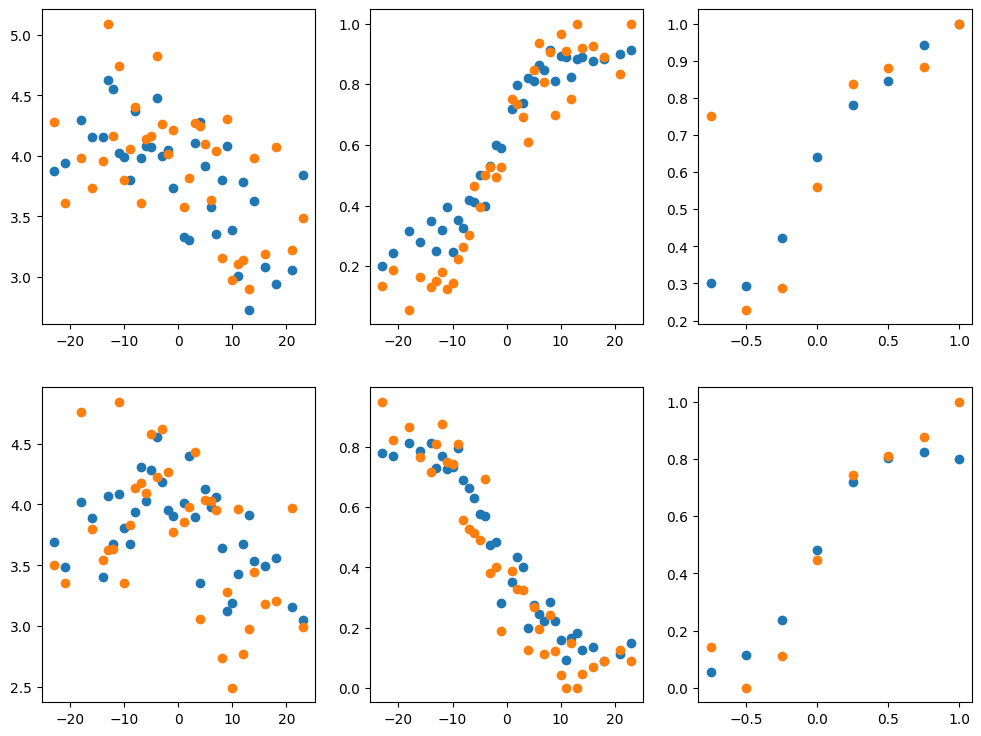

In [12]:
plt.figure(figsize=(12, 9))
plt.subplot(231)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(232)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(233)
plt.scatter(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

###########
plt.subplot(234)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(235)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(236)
plt.scatter(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
            y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

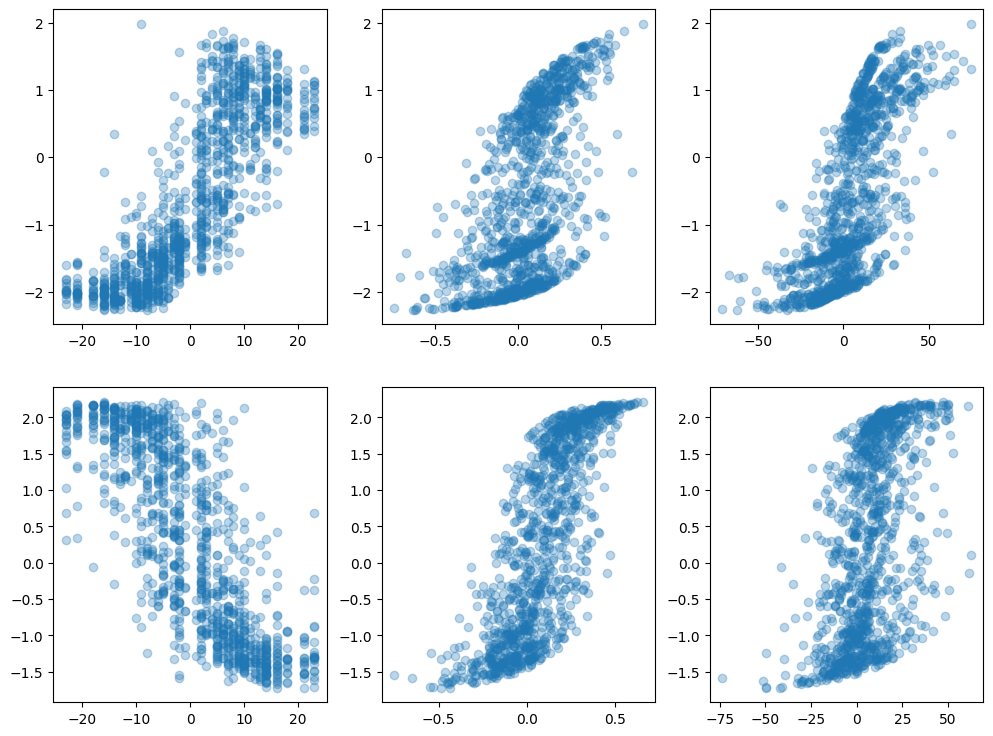

In [13]:
plt.figure(figsize=(12, 9))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 0] - X_test[X_test[:, -1]==1, 1], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 2] - X_test[X_test[:, -1]==1, 3], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2] - X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3], 
            pred_v[X_test[:, -1]==1, 0] - pred_v[X_test[:, -1]==1, 1], alpha=0.3);

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 0] - X_test[X_test[:, -1]==-1, 1], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 2] - X_test[X_test[:, -1]==-1, 3], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2] - X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3], 
            pred_v[X_test[:, -1]==-1, 0] - pred_v[X_test[:, -1]==-1, 1], alpha=0.3);